# Predicting Tax Value for Single Family Homes

by Braeden Wright
03-30-2022

## Project Goal

- Find the key drivers of property value for single family properties and construct an ML Regression model that will predict property tax assessed values (tax_value) for those homes.


## Initial Questions

- Does more square footage have a linear relation to  tax value, as I suspect it to?
- Would the year the house was built positively or negatively affect tax value?
- Will the geographical location(fips) be useful, or does it skew the data?

## Data Dictionary


   #### Feature   ----->     Discription
   -----------------------------
   - tax_value -----> The total tax assessed value of the parcel. Also our y variable
   - year_built ----> The Year the principal residence was built 
   - fips ----------> Federal Information Processing Standard code -  see https://en.wikipedia.org/wiki/FIPS_county_code for more details
   - sqr_feet ------> Calculated total finished living area of the home 
   - bedrooms ------> Number of bedrooms in home 
   - bathrooms -----> Number of bathrooms in home 

# Imports

In [42]:
# Foundation
import pandas as pd
import numpy as np
from scipy import math

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Metric and Modeling Tools
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Custom
import wrangle_prep as wp
import explore as ep


# Required Data
df = wp.wrangle_zillow()
df.head(3)

Reading cleaned data from csv file...


,bedrooms,bathrooms,sqr_feet,tax_value,year_built,fips
0,4.0,2.0,3633.0,296425.0,2005,6037
1,3.0,2.0,1222.0,290492.0,1951,6037
2,3.0,2.5,1821.0,537949.0,2013,6059


- In addition to pulling the data, the wrangle_zillow function also cleans the data and removes outliers that I found reduced the efficiency of the models. (For more details on how I came to these conclusions, see the zillow_workbook.ipynb)
- I pulled only the features I concluded would best benefit the model, and quckly make sure they are all the proper data types.

In [3]:
df.year_built = df.year_built.astype(object)
df.fips = df.fips.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355481 entries, 0 to 1355480
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1355481 non-null  float64
 1   bathrooms   1355481 non-null  float64
 2   sqr_feet    1355481 non-null  float64
 3   tax_value   1355481 non-null  float64
 4   year_built  1355481 non-null  object 
 5   fips        1355481 non-null  object 
dtypes: float64(4), object(2)
memory usage: 62.0+ MB


### Data Splits

In [4]:
# Data Split
train, validate, test = wp.split_data(df)

train <> (759068, 6)
validate <> (325316, 6)
test <> (271097, 6)


In [5]:
# Variables for models

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value

In [6]:
# Scaling

# Make it
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit it
scaler.fit(x_train)

# Use it
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

# Exploration

### I started by comparing my features against each other with a few methods
- Heatmap of continuous features
- RFE rankings
- K Best

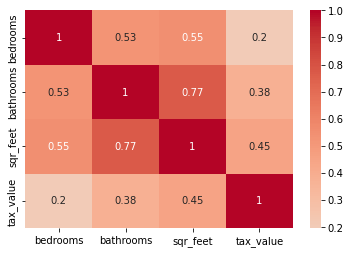

In [7]:
# Heatmap
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True)
plt.show()

In [8]:
# RFE Ranking
ep.rfe_feature_rankings(x_train_scaled, x_train, y_train, 1)

,Var,Rank
2,sqr_feet,1
1,bathrooms,2
0,bedrooms,3
3,year_built,4
4,fips,5


In [11]:
# KBest
kbest = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.f_regression, k=2)
kbest.fit(x_train_scaled, y_train)
kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train.columns)
kbest_results

,p,f
bedrooms,0.0,30304.193347
bathrooms,0.0,129406.449924
sqr_feet,0.0,195663.134174
year_built,0.0,77177.449390
fips,0.0,9086.959230


### These three test's seem to confirm that that the square footage of a home will more than likely indicate correlation.

### I used this going forward to explore other features

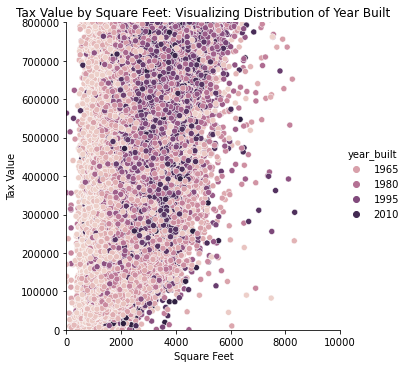

In [20]:
# Distribution of Year Home was Built
sns.relplot(x='sqr_feet', y='tax_value', data=train, hue='year_built').set(xlim=(0,10000),ylim=(0,800000))
plt.title('Tax Value by Square Feet: Visualizing Distribution of Year Built')
plt.xlabel('Square Feet')
plt.ylabel('Tax Value')
plt.show()

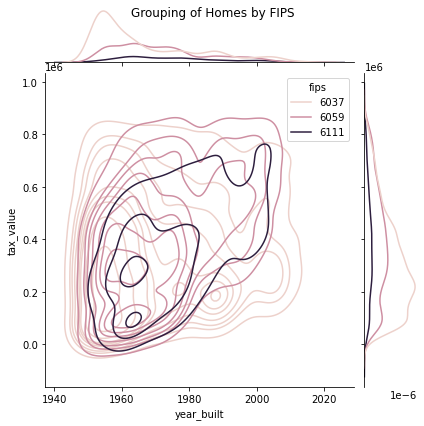

In [27]:
# sample of the data
sample = train.sample(10000)

sns.jointplot('year_built', 'tax_value', data=sample, hue='fips', kind='kde')
plt.suptitle('Grouping of Homes by FIPS')
plt.show()

- Originally when I looked at the data, I noticed that a majority of the homes built before the year 1950 were from LA County (fips code 6037). This skewed the model slightly to favor homes with that fips code, so for the final draft I narrowed my data to homes built later than 1950 so that the different fips locations were more evenly distributed.  This lead to  small improvements in the model.

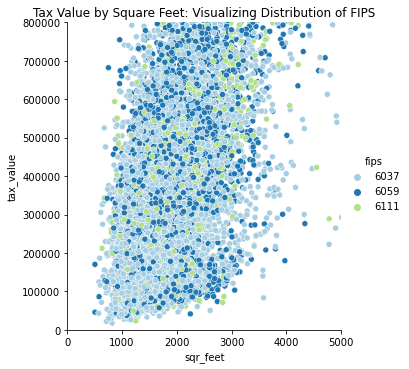

In [61]:
# FIPS Distribution
sns.relplot(x='sqr_feet', y='tax_value', data=sample, hue='fips', palette='Paired').set(xlim=(0,5000),ylim=(0,800000))
plt.title('Tax Value by Square Feet: Visualizing Distribution of FIPS')
plt.show()

- LA County(6037) still leads in numbers, but Orange County(6059) and Ventura County(6111) both tend to have higher average tax values.  
--------------------------------------
### Based on the exploration and visualizations of the data, we can say:


   - Does more square footage have a linear relation to tax value, as I suspect it to?
   #### Yes, square footage is one of our best indicators for tax value and will be a useful feature for modeling
   ----
   - Would the year the house was built positively or negatively affect tax value?
   #### While the tax value of homes built in the same year can vary, homes built more recently tend to have higher tex rates
   ----
   - Will the geographical location(fips) be useful, or does it skew the data?
   #### FIPS was useful for filtering the data and removing outliers, and  it's confirmed that some FIPS can lean towards a higher tax value than others
----

# Building the Models

In [28]:
# train
predictions = pd.DataFrame()
predictions['actual'] = train.tax_value
predictions['baseline'] = train.tax_value.median()

# validate
validate_predictions = pd.DataFrame()
validate_predictions['actual'] = validate.tax_value
validate_predictions['baseline'] = validate.tax_value.median()

In [29]:
# Our 'Adv. Baseline' is just a simple linear regression based off sqr_feet

x_train_bl = x_train[['sqr_feet']]
x_validate_bl = x_validate[['sqr_feet']]

model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train_bl, y_train)
predictions['adv_baseline'] = model.predict(x_train_bl)

# validate
validate_predictions['adv_baseline_validate'] = model.predict(x_validate_bl)

# score
model.score(x_train_bl, y_train)

0.20494099024532597

In [30]:
# The math behind our advanced baseline model
m, b = model.coef_[0], model.intercept_

print(f'Tax Value = {m:.4f} x sqr_feet + {b:.4f}')

Tax Value = 139.5839 x sqr_feet + 93550.6824


### Multiple Regression

In [32]:
# multiple regression
model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train, y_train)
predictions['multi_regression'] = model.predict(x_train)

# validate
validate_predictions['multi_regression_validate'] = model.predict(x_validate)

# score
model.score(x_train, y_train)

0.2254990052769058

### Multiple Regression with RFE

In [34]:
# Multiple regression with RME
model = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(model, n_features_to_select=4)

# train
rfe.fit(x_train, y_train)
x_train_rfe = rfe.transform(x_train)
model.fit(x_train_rfe, y_train)
predictions['multiple_rfe'] = model.predict(x_train_rfe)

# validate
x_validate_rfe = rfe.transform(x_validate)
validate_predictions['multiple_rfe_validate'] = model.predict(x_validate_rfe)

# score
model.score(x_train_rfe, y_train)

0.17071821333188353

### K Nearest Neighbors

In [37]:
# KNN (k=2)
model = KNeighborsRegressor(n_neighbors=2)

# train
model.fit(x_train_scaled, y_train)
predictions['KNN(k=2)'] = model.predict(x_train)

# validate
validate_predictions['KNN(k=2)_validate'] = model.predict(x_validate)

# score
model.score(x_train_scaled, y_train)

0.3484468869343903

### Polynomial

In [38]:
# Polynomial (degree=2)
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False,  interaction_only=False)

# train
poly.fit(x_train)

x_train_poly = pd.DataFrame(poly.transform(x_train),
    columns=poly.get_feature_names(x_train.columns),
    index=train.index,
)

# validate
x_validate_poly = pd.DataFrame(poly.transform(x_validate),
    columns=poly.get_feature_names(x_validate.columns),
    index=validate.index,
)

# add it to our list
model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train_poly, y_train)
predictions['poly(degree=2)'] = model.predict(x_train_poly)

# validate
validate_predictions['poly(degree=2)_validate'] = model.predict(x_validate_poly)

# score
model.score(x_train_poly, y_train)

0.25340673615035825

In [39]:
predictions.head(3)

,actual,baseline,adv_baseline,multi_regression,multiple_rfe,KNN(k=2),poly(degree=2)
1246314,471141.0,322462.0,405520.669795,428553.912380,427000.130582,386417.5,475979.476039
632828,416251.0,322462.0,283384.768707,248849.158881,286123.751759,409811.0,253020.514469
708196,407927.0,322462.0,297482.741290,278896.887160,280452.588414,409811.0,293794.182646


In [40]:
validate_predictions.head(3)

,actual,baseline,adv_baseline_validate,multi_regression_validate,multiple_rfe_validate,KNN(k=2)_validate,poly(degree=2)_validate
1204293,409465.0,322026.0,432879.111638,438604.142274,429076.623084,386417.5,467167.915497
408182,283981.0,322026.0,464983.405639,444947.832075,437308.374330,386417.5,423606.953788
136758,223649.0,322026.0,340893.330133,296179.946380,282403.739280,450729.5,305736.247648


### Model Comparison

In [43]:
# Compare how these models work on the train sample
pd.concat([
    predictions.apply(lambda col: r2_score(predictions.actual, col)).rename('r2'),
    predictions.apply(lambda col: mean_squared_error(predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.016108,4.017719e+10,200442.480558
adv_baseline,0.204941,3.143684e+10,177304.377738
multi_regression,0.225499,3.062397e+10,174997.065814
multiple_rfe,0.170718,3.279002e+10,181080.147906
KNN(k=2),-0.302609,5.150550e+10,226948.232092
poly(degree=2),0.253407,2.952049e+10,171815.290427


In [44]:
# Compare how these models work on the validate sample
pd.concat([
    validate_predictions.apply(lambda col: r2_score(validate_predictions.actual, col)).rename('r2'),
    validate_predictions.apply(lambda col: mean_squared_error(validate_predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.015997,4.003649e+10,200091.206667
adv_baseline_validate,0.202878,3.141147e+10,177232.801013
multi_regression_validate,0.223230,3.060948e+10,174955.659504
multiple_rfe_validate,0.169097,3.274265e+10,180949.309862
KNN(k=2)_validate,-0.302645,5.133217e+10,226566.031189
poly(degree=2)_validate,0.251142,2.950960e+10,171783.587787


- The RMSE for each model is much higher than I would've hoped, however serveal models improve upon the adv. baseline, so there is at least improvement.
- The Polynomial Model seems to provide the best metics, and indicates that it would most closely calculate tax value.  For this reason it will be the only model used on the test sample.

In [65]:
# TEST
test_predictions = pd.DataFrame()
test_predictions['actual'] = test.tax_value
test_predictions['baseline'] = test.tax_value.median()

# Polynomial (degree=2)
# Make it
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False,  interaction_only=False)

# Fit it
poly.fit(x_train)

x_test_poly = pd.DataFrame(poly.transform(x_test),
    columns=poly.get_feature_names(x_test.columns),
    index=test.index,
)

model = sklearn.linear_model.LinearRegression()
model.fit(x_train_poly, y_train)

# Use it
test_predictions['Polynomial'] = model.predict(x_test_poly)

# score
model.score(x_test_poly, y_test)

0.2501841901158389

# Final Metrics

In [49]:
pd.concat([
    test_predictions.apply(lambda col: r2_score(test_predictions.actual, col)).rename('r2'),
    test_predictions.apply(lambda col: mean_squared_error(test_predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.016079,4.011675e+10,200291.672021
Polynomial,0.250184,2.960417e+10,172058.637093


In [51]:
test_predictions.head(5)

,actual,baseline,Polynomial
705135,241330.0,322250.0,217285.412193
89031,351173.0,322250.0,316564.265227
734275,207719.0,322250.0,208697.527780
174436,256012.0,322250.0,336818.171407
515799,410048.0,322250.0,368788.144914


In [52]:
test_predictions.describe()

,actual,baseline,Polynomial
count,271097.000000,271097.0,2.710970e+05
mean,347445.730624,322250.0,3.477047e+05
std,198700.967983,0.0,1.007000e+05
min,102.000000,322250.0,-5.436014e+06
25%,190920.000000,322250.0,2.746232e+05
50%,322250.000000,322250.0,3.277131e+05
75%,480407.000000,322250.0,4.039080e+05
max,847704.000000,322250.0,1.096335e+06



# Conclusion
   - The Polynomial Model calculates the tax value for a single family properties with a R^2 score of 0.25, getting the tax value within an average of 172,058.64(dolars) away from our actual.  A much larger margin of error than we would like, but an improvement upon the baseline(200,291.67) and even the advance baseline(177,232.80).
####   - Our model can still be improved upon with more time and potentially more data!
    
    
## Going forward..
   - To better improve the model wee need our zillow database to be reworked, with more readily available data.  What made it hardest to really refine the model and reduce the error was how limited some of the available features were.  Number of Stories or if the property had a Pool, Porch, etc., all of these had too much missing data to allow us to use them.  If we can complete these missing values, it would significantly increase our model's potential.
   - We could then rework our models to build upon the insights learned here. 


----------------------------
   - Code used to acquire and prepare the data, and additional work done by Braeden Wright can be found at https://github.com/BraedenWright/regression-project